# SHAP-IQ with scikit-learn

In this example, we use the popular California housing dataset for regression available at https://www.kaggle.com/datasets/camnugent/california-housing-prices.

### Import Packages

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import shapiq

shapiq.__version__

/Users/max/PycharmProjects/shapiq/venv_13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.2.1.dev'

### Load Data
Let's load the California housing dataset and split it into training and test sets.

In [2]:
X, y = shapiq.load_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)
n_features = X_train.shape[1]

### Train a Model with Scikit-learn
Here we train a random forest regressor with 500 trees.
The model achieves a relatively high R2 score on the test set.

In [3]:
model = RandomForestRegressor(
    n_estimators=500, max_depth=n_features, max_features=2 / 3, max_samples=2 / 3, random_state=42
)
model.fit(X_train, y_train)
print("Train R2: {:.4f}".format(model.score(X_train, y_train)))
print("Test  R2: {:.4f}".format(model.score(X_test, y_test)))

Train R2: 0.7990
Test  R2: 0.7462


### Model-Agnostic Explainer

We use `shapiq.TabularExplainer` to explain any machine learning model for tabular data. 

It has the following basic parameters:

- `model`: The model to be explained as a callable function expecting data points as input and returning 1-dimensional predictions.

- `data`: A background dataset to be used for imputation.

In [4]:
explainer_tabular = shapiq.TabularExplainer(model=model, data=X_train, index="SII", max_order=2)

Next, select an instance to be explained.

In [5]:
x = X_test[24]

Call an `explain()` interface setting the `budget`, i.e. the maximum number of model evaluations (coallitions).

In [6]:
interaction_values = explainer_tabular.explain(x, budget=2**n_features, random_state=0)
interaction_values

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.0699756848160713
)

An output is stored in the `shapiq.InteractionValues` object. Its main attribute is `dict_values` storing Shapley interaction values as a dictionary.

In [7]:
interaction_values.dict_values

{(): 2.0699756848160713,
 (0,): 0.08480451405672634,
 (1,): -0.0832989329240868,
 (2,): -0.03128312000474831,
 (3,): -0.012803693993918348,
 (4,): -0.008899047714401465,
 (5,): -0.14060496160696606,
 (6,): 0.1681986730009342,
 (7,): -0.2837059316398061,
 (0, 1): -0.019510230813163616,
 (0, 2): 0.016056201888051357,
 (0, 3): 0.01152755641248399,
 (0, 4): 0.014594749842733975,
 (0, 5): -0.06079229286566206,
 (0, 6): -0.05620125831374121,
 (0, 7): 0.061609501512216745,
 (1, 2): 0.014383549298892327,
 (1, 3): 0.01621627062057581,
 (1, 4): 0.014431042135545573,
 (1, 5): 0.10331389411864193,
 (1, 6): 0.011754881116425536,
 (1, 7): 0.013116173757552575,
 (2, 3): 0.013325122962969324,
 (2, 4): 0.014613588631227987,
 (2, 5): 0.012802475087828554,
 (2, 6): 0.015072589844610232,
 (2, 7): 0.008019847712928942,
 (3, 4): 0.014712919195619883,
 (3, 5): 0.01775692706561018,
 (3, 6): 0.012938155262723247,
 (3, 7): 0.013644555074274076,
 (4, 5): 0.007957862811075179,
 (4, 6): 0.014073324556933895,
 (4, 

One can retrieve only 2-order values with `get_n_order(2)` (object) and `get_n_order_values(2)` (values themselves).

In [8]:
interaction_values.get_n_order(2).dict_values

{(0, 1): -0.019510230813163616,
 (0, 2): 0.016056201888051357,
 (0, 3): 0.01152755641248399,
 (0, 4): 0.014594749842733975,
 (0, 5): -0.06079229286566206,
 (0, 6): -0.05620125831374121,
 (0, 7): 0.061609501512216745,
 (1, 2): 0.014383549298892327,
 (1, 3): 0.01621627062057581,
 (1, 4): 0.014431042135545573,
 (1, 5): 0.10331389411864193,
 (1, 6): 0.011754881116425536,
 (1, 7): 0.013116173757552575,
 (2, 3): 0.013325122962969324,
 (2, 4): 0.014613588631227987,
 (2, 5): 0.012802475087828554,
 (2, 6): 0.015072589844610232,
 (2, 7): 0.008019847712928942,
 (3, 4): 0.014712919195619883,
 (3, 5): 0.01775692706561018,
 (3, 6): 0.012938155262723247,
 (3, 7): 0.013644555074274076,
 (4, 5): 0.007957862811075179,
 (4, 6): 0.014073324556933895,
 (4, 7): 0.015295493506213512,
 (5, 6): -0.0012000526679741045,
 (5, 7): 0.041781657131926254,
 (6, 7): -0.05015262457164427}

In [9]:
interaction_values.get_n_order_values(2)

array([[ 0.08480451, -0.01951023,  0.0160562 ,  0.01152756,  0.01459475,
        -0.06079229, -0.05620126,  0.0616095 ],
       [-0.01951023, -0.08329893,  0.01438355,  0.01621627,  0.01443104,
         0.10331389,  0.01175488,  0.01311617],
       [ 0.0160562 ,  0.01438355, -0.03128312,  0.01332512,  0.01461359,
         0.01280248,  0.01507259,  0.00801985],
       [ 0.01152756,  0.01621627,  0.01332512, -0.01280369,  0.01471292,
         0.01775693,  0.01293816,  0.01364456],
       [ 0.01459475,  0.01443104,  0.01461359,  0.01471292, -0.00889905,
         0.00795786,  0.01407332,  0.01529549],
       [-0.06079229,  0.10331389,  0.01280248,  0.01775693,  0.00795786,
        -0.14060496, -0.00120005,  0.04178166],
       [-0.05620126,  0.01175488,  0.01507259,  0.01293816,  0.01407332,
        -0.00120005,  0.16819867, -0.05015262],
       [ 0.0616095 ,  0.01311617,  0.00801985,  0.01364456,  0.01529549,
         0.04178166, -0.05015262, -0.28370593]])

### Visualization of Shapley interactions

`shapiq` includes the following plotting functions:

- [network_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.network_plot)

- [stacked_bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.stacked_bar_plot)

- [force_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.force_plot)

- and [bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.bar_plot) for global feature (interaction) importance.

For details of their parameters, refer to the [API reference](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html).

(<Figure size 600x600 with 1 Axes>, <Axes: >)

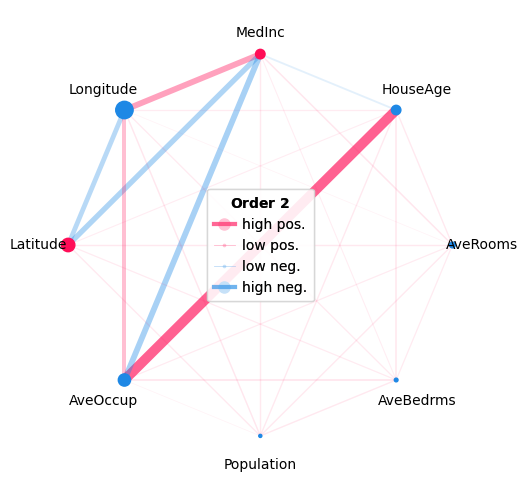

In [10]:
shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

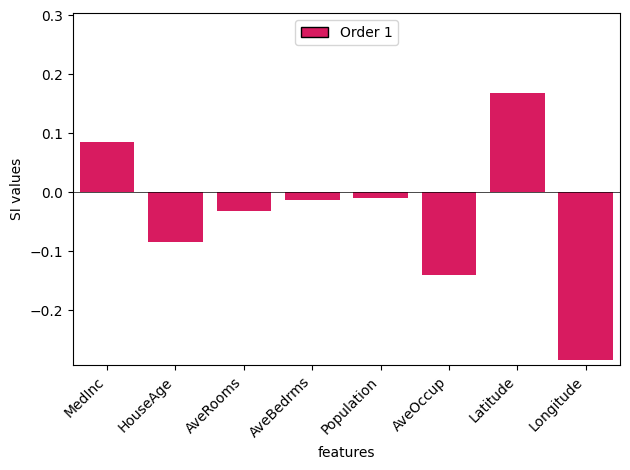

In [11]:
_ = shapiq.stacked_bar_plot(
    interaction_values.get_n_order(1),
    feature_names=X.columns,
)

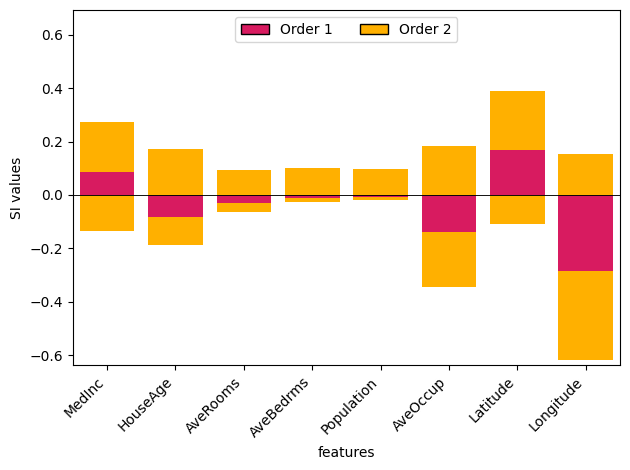

In [12]:
_ = shapiq.stacked_bar_plot(
    interaction_values=interaction_values,
    feature_names=X.columns,
)

After installing the `shap` Python package.

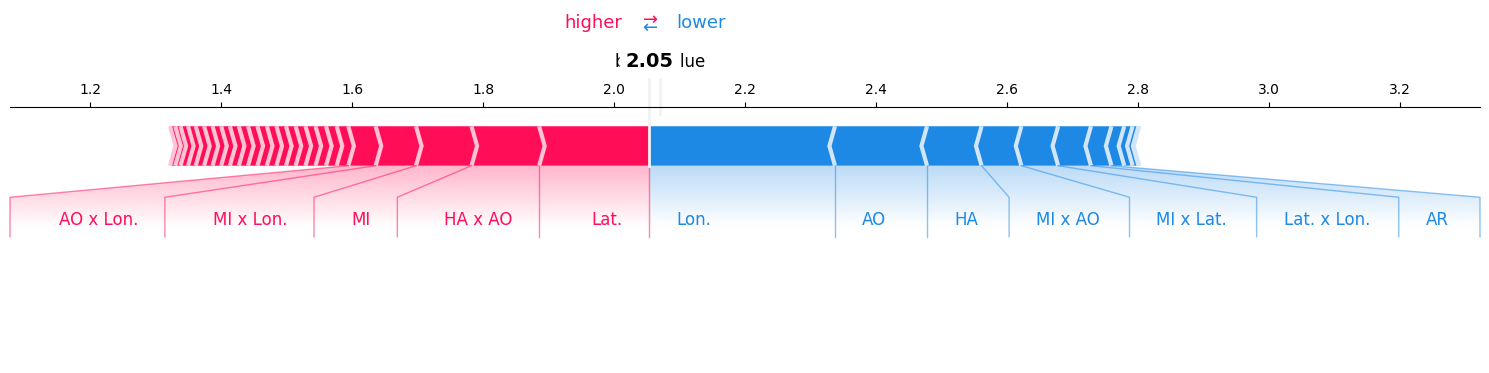

In [14]:
interaction_values.plot_force(feature_names=X.columns)